In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
from autokeras.keras_layers import ExpandLastDim
from autokeras.keras_layers import CastToFloat32
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, LSTM, SimpleRNN
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation, RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.applications import EfficientNetB7
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Make Input

In [3]:
def calculateWeight(tlx):
    tlx_weight = {'Mental':[0], 
                  'Physical':[0], 
                  'Temporal':[0], 
                  'Effort':[0],
                  'Performance':[0],
                  'Frustration':[0],
                  'Sum':[0]}
    tlx_weight = pd.DataFrame(tlx_weight)
    for i in range(len(tlx)):
        score = [0,0,0,0,0,0,0]
        for col1 in range(1,len(tlx.columns)):
            for col2 in range(col1+1, len(tlx.columns)):
                if tlx[tlx.columns[col1]][i] > tlx[tlx.columns[col2]][i]:
                    score[col1-1]+=1
                elif tlx[tlx.columns[col1]][i] < tlx[tlx.columns[col2]][i]:
                    score[col2-1]+=1
                else :
                    score[col1-1]+=0.5
                    score[col2-1]+=0.5
                    
        score[6] = score[0]+score[1]+score[2]+score[3]+score[4]+score[5]
        tlx_weight.loc[i]=score
    #print(tlx_weight.loc[0])
    return tlx_weight

def calculate_tlxLevel(tlx, tlx_weight):
    result = {'Mental':[0], 
                  'Physical':[0], 
                  'Temporal':[0], 
                  'Effort':[0],
                  'Performance':[0],
                  'Frustration':[0],
                  'Score':[0]}
    result = pd.DataFrame(result)
    for i in range(len(tlx)):
        score = [0,0,0,0,0,0,0]
        for col in range(len(tlx_weight.columns)-1):
            score[col] = int(tlx[tlx.columns[col+1]].loc[i] * tlx_weight[tlx_weight.columns[col]].loc[i] )
        score[6] =int((score[0]+score[1]+score[2]+score[3]+score[4]+score[5] )/ tlx_weight[tlx_weight.columns[6]].loc[i]/10 + 0.5)
        if score[6]>10: score[6]=10
        if score[6]<0: score[6]=0
        result.loc[i]=score
    return result['Score']

In [4]:
def split_data(df, label, end):
    col = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7',
           'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4',
           'EEG.F8', 'EEG.AF4', 'MarkerValueInt']
    col_rename = ['AF3', 'F7', 'F3', 'FC5', 'T7',
           'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4',
           'F8', 'AF4', 'vis_name']
    data_extraction = df[col]
    data_extraction.columns = col_rename
    rest = data_extraction[data_extraction.vis_name == 0]
    survey = data_extraction[data_extraction.vis_name == 100]
    
    vis = data_extraction[data_extraction.vis_name == 1].reset_index(drop=True)
    vis['label'] = label[0]
    vis.drop(['vis_name'], axis=1, inplace=True)
    
    for i in range(2,end):
        df = data_extraction[data_extraction.vis_name == i].reset_index(drop=True)
        df['label'] = label[i-1]
        df.drop(['vis_name'], axis=1, inplace=True)
        vis = pd.concat([vis,df], ignore_index=True, axis=0)
    return rest, survey, vis

In [6]:
src = 'EEG data/User/'
files = os.listdir(src)
tlx=[]
for f in files:
    tlx.append(pd.read_csv(src+f))
src = 'EEG data/prepross/'
datas = os.listdir(src)
workloadLevel = []
for t in tlx:
    workloadLevel.append(calculate_tlxLevel(t, calculateWeight(t)))
eegData=[]
for d in datas:
    eegData.append(pd.read_csv(src+d))
    
cnt = 0
for eeg, label in zip (eegData, workloadLevel):
    if cnt == 0 :
        rest, survey, vis = split_data(eeg, label,21)
        cnt+=1
        continue
    elif cnt == 6:
        r, s, v = split_data(eeg, label,21)
    else:
        r, s, v = split_data(eeg, label, 22)
    
    rest = pd.concat([rest,r], ignore_index=True, axis=0)
    survey = pd.concat([survey,s], ignore_index=True, axis=0)
    vis = pd.concat([vis,v], ignore_index=True, axis=0)
    cnt+=1

In [7]:
label=vis['label']
label = to_categorical(label,11)
data=vis.drop(['label'],axis=1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
data = pd.DataFrame(scaled, columns = data.columns, index=data.index)
data
print(label.shape)

(1731369, 11)


In [8]:
def windowing_dataset(data, label, window_size):
    data_list = []
    label_list = []
    
    for i in range(0,len(data)//window_size,window_size):
        data_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i]))
    return np.array(data_list), np.array(label_list)

In [9]:
x, y = windowing_dataset(data,pd.DataFrame(label),14)
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.6, 
                                                    random_state=True,
                                                    stratify = y)
x_valid, x_test, y_valid, y_test = train_test_split(x_test,y_test, train_size=0.6, 
                                                    random_state=True,
                                                    stratify = y_test)

print(x_train.shape, x_test.shape, x_valid.shape,y_valid.shape,y_train.shape, y_test.shape)

(5300, 14, 14) (1414, 14, 14) (2120, 14, 14) (2120, 11) (5300, 11) (1414, 11)


In [11]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def drawResult(history):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()
    
def runModel(model, crossentropy, x_train, y_train, x_valid, y_valid):
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model.compile(optimizer='adam', loss= crossentropy, metrics='accuracy')

    history = model.fit(x_train, y_train, 
                        epochs = 200, 
                        validation_data = (x_valid, y_valid), 
                        callbacks=[early_stop], verbose=1)
    drawResult(history)
    return model

def eval_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    return f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')

In [10]:
def Model2_2_1():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(11, activation='sigmoid'))
    
    #model.summary()
    return model

def Model2_2_2():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dense(11, activation='sigmoid'))
    
    model.summary()
    return model

def Model2_2_3():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(11, activation='sigmoid'))
    
    #model.summary()
    return model

Epoch 1/200
166/166 [==============================] - 14s 47ms/step - loss: 1.1024 - accuracy: 0.4509 - val_loss: 1.0892 - val_accuracy: 0.4665
Epoch 2/200
166/166 [==============================] - 7s 42ms/step - loss: 1.0706 - accuracy: 0.4502 - val_loss: 1.0593 - val_accuracy: 0.4665
Epoch 3/200
166/166 [==============================] - 7s 42ms/step - loss: 1.0686 - accuracy: 0.4449 - val_loss: 1.0594 - val_accuracy: 0.4160
Epoch 4/200
166/166 [==============================] - 7s 44ms/step - loss: 1.0621 - accuracy: 0.4543 - val_loss: 1.0583 - val_accuracy: 0.4665
Epoch 5/200
166/166 [==============================] - 7s 44ms/step - loss: 1.0624 - accuracy: 0.4460 - val_loss: 1.0568 - val_accuracy: 0.4665
Epoch 6/200
166/166 [==============================] - 7s 45ms/step - loss: 1.0637 - accuracy: 0.4653 - val_loss: 1.0557 - val_accuracy: 0.4665
Epoch 7/200
166/166 [==============================] - 7s 44ms/step - loss: 1.0613 - accuracy: 0.4538 - val_loss: 1.0549 - val_accuracy

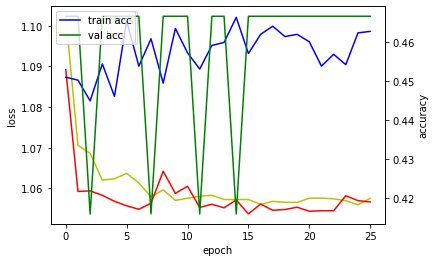

0.15894838398456343
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_last_dim_1 (ExpandLas (None, 14, 14, 1)         0         
_________________________________________________________________
cast_to_float32_1 (CastToFlo (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 512)       2560      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 512)       1049088   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
conv2d_5 (Conv2D)            (None

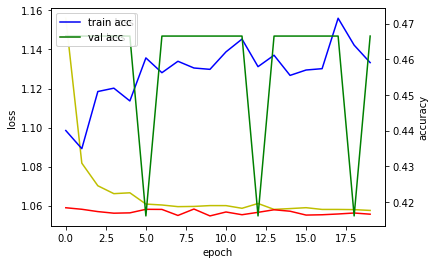

0.15894838398456343
Epoch 1/200
166/166 [==============================] - 7s 37ms/step - loss: 1.2957 - accuracy: 0.4332 - val_loss: 1.0899 - val_accuracy: 0.4665
Epoch 2/200
166/166 [==============================] - 6s 34ms/step - loss: 1.1292 - accuracy: 0.4523 - val_loss: 1.1205 - val_accuracy: 0.4160
Epoch 3/200
166/166 [==============================] - 6s 34ms/step - loss: 1.1070 - accuracy: 0.4443 - val_loss: 1.0642 - val_accuracy: 0.4665
Epoch 4/200
166/166 [==============================] - 6s 34ms/step - loss: 1.0854 - accuracy: 0.4530 - val_loss: 1.0579 - val_accuracy: 0.4665
Epoch 5/200
166/166 [==============================] - 6s 35ms/step - loss: 1.0860 - accuracy: 0.4470 - val_loss: 1.0564 - val_accuracy: 0.4665
Epoch 6/200
166/166 [==============================] - 6s 36ms/step - loss: 1.0813 - accuracy: 0.4604 - val_loss: 1.0618 - val_accuracy: 0.4665
Epoch 7/200
166/166 [==============================] - 6s 33ms/step - loss: 1.0802 - accuracy: 0.4628 - val_loss: 1.

KeyboardInterrupt: 

In [12]:
crossentropy = 'categorical_crossentropy'

print(eval_model(runModel(Model2_2_1(),crossentropy,
                          x_train, y_train, x_valid, y_valid), x_test, y_test))
print(eval_model(runModel(Model2_2_2(),crossentropy,
                          x_train, y_train, x_valid, y_valid), x_test, y_test))
print(eval_model(runModel(Model2_2_3(),crossentropy,
                          x_train, y_train, x_valid, y_valid), x_test, y_test))

In [ ]:
def Model2_1_1():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(11, activation='sigmoid'))
    
    #model.summary()
    return model

def Model2_1_2():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dense(11, activation='sigmoid'))
    
    #model.summary()
    return model

def Model2_1_3():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(11, activation='sigmoid'))
    
    #model.summary()
    return model

crossentropy = 'categorical_crossentropy'

print(eval_model(runModel(Model2_1_1(),crossentropy,
                          x_train, y_train, x_valid, y_valid), x_test, y_test))
print(eval_model(runModel(Model2_1_2(),crossentropy,
                          x_train, y_train, x_valid, y_valid), x_test, y_test))
print(eval_model(runModel(Model2_1_3(),crossentropy,
                          x_train, y_train, x_valid, y_valid), x_test, y_test))

# AUTO KERAS

In [21]:
import autokeras as ak
from tensorflow.keras.utils import plot_model
from datetime import datetime

In [18]:
x, y = windowing_dataset(data,pd.DataFrame(label),14)
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.6, 
                                                    random_state=True,
                                                    stratify = y)

print(x_train.shape, x_test.shape,y_train.shape, y_test.shape)

In [22]:
trials=[3] #,5,10,20]
for trial in trials:
    clf_ = ak.ImageClassifier(overwrite=True, max_trials=trial)
    clf_.fit(x=x_train, y=y_train, epochs=20)

    predicted_y = clf_.predict(x_test)
    print(predicted_y)
    loss, acc = clf_.evaluate(x_test, y_test)
    print(clf_.evaluate(x_test, y_test))
    print('Loss: %.3f   Accuracy: %.3f' % (loss,acc))

    model = clf_.export_model()
    model.summary()
    plot_model(model, show_shapes=True)
    tmp = int(acc*100)
    print(tmp)
    model.save('model/'+'_ACC_'+str(tmp)+'_try_'+trial+'_.h5')

Trial 2 Complete [00h 33m 50s]
val_loss: 1.1219675540924072

Best val_loss So Far: 0.927096426486969
Total elapsed time: 00h 34m 29s

Search: Running Trial #3

Hyperparameter    |Value             |Best Value So Far 
image_block_1/b...|efficient         |vanilla           
image_block_1/n...|True              |True              
image_block_1/a...|True              |False             
image_block_1/i...|True              |None              
image_block_1/i...|False             |None              
image_block_1/i...|0                 |None              
image_block_1/i...|0                 |None              
image_block_1/i...|0.1               |None              
image_block_1/i...|0                 |None              
image_block_1/e...|True              |None              
image_block_1/e...|b7                |None              
image_block_1/e...|True              |None              
image_block_1/e...|True              |None              
classification_...|global_avg        |flat

KeyboardInterrupt: 